# Cogs 118C Final Project

## Anand Mysorekar, Leo Fleury, & Ava Rubin

# Loading Data

In [1]:
from scipy import io
from scipy.signal import butter, filtfilt, iirnotch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy import signal
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection


In [2]:
# Acessing AD & control 

control_path = r'Control_EEG_sub_027.npy'
control = np.load(control_path) * 1e6
ad_path = r'AD_EEG_sub_001.npy'
AD = np.load(ad_path) * 1e6

In [3]:
fs = 500
num_samples = control.shape[1]
duration = num_samples / fs

time = np.linspace(0, duration , num_samples)

channels = ['Fp1', 'Fp2', 'F3']
colors = ['r', 'g', 'b']

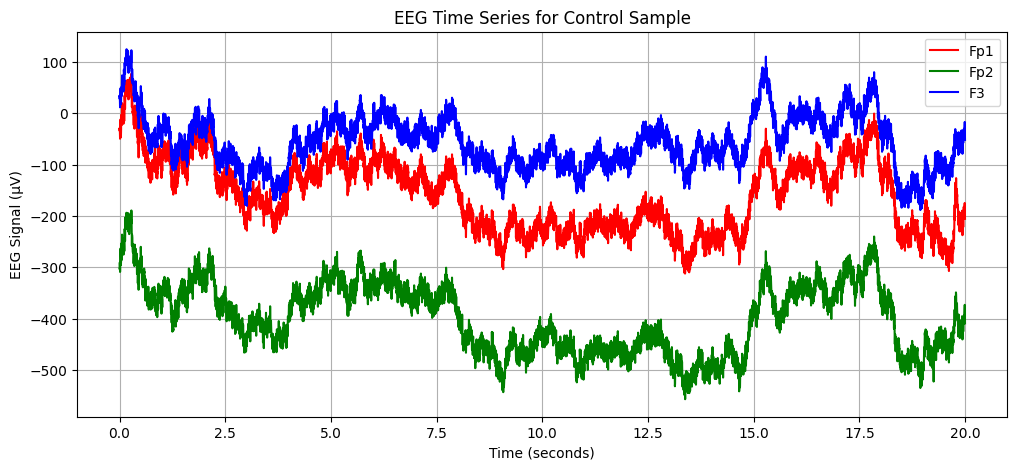

In [4]:
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(time, control[i, :], label=channels[i], color=colors[i])

plt.xlabel("Time (seconds)")
plt.ylabel("EEG Signal (µV)")
plt.title("EEG Time Series for Control Sample")
plt.legend()
plt.grid(True)

plt.show()

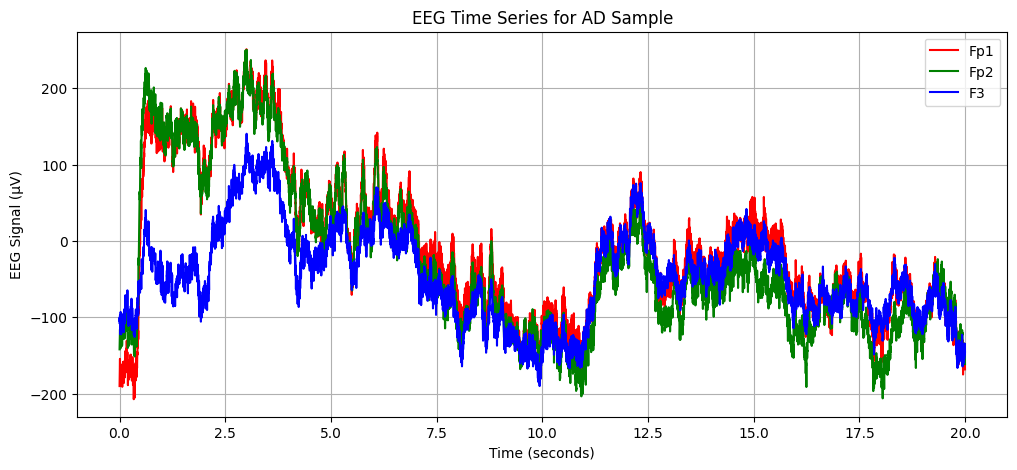

In [5]:
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(time, AD[i, :], label=channels[i], color=colors[i])

plt.xlabel("Time (seconds)")
plt.ylabel("EEG Signal (µV)")
plt.title("EEG Time Series for AD Sample")
plt.legend()
plt.grid(True)

plt.show()

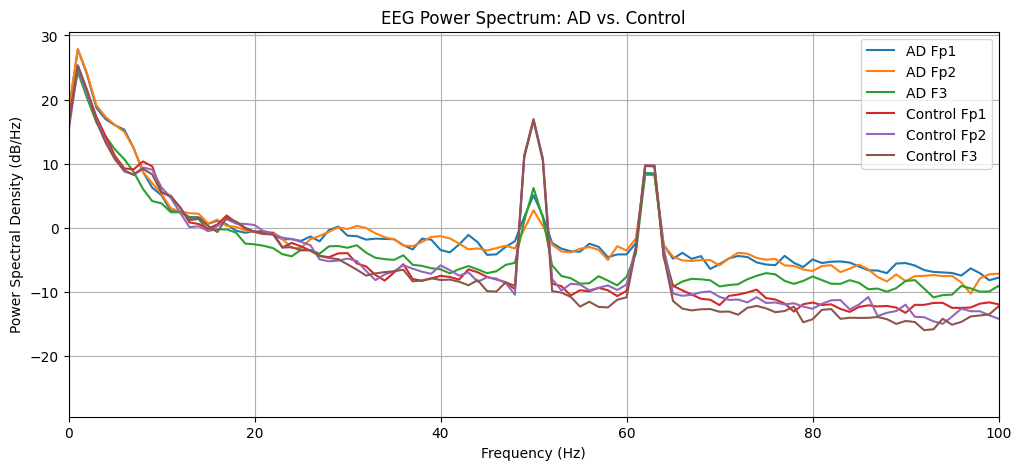

In [6]:
def plot_psd(signal, fs,condition):
    """Plots absolute power in theta/gamma bands between control and AD groups for all subjects."""
    freqs, psd = welch(signal, fs=fs, window='hann', nperseg=500, noverlap=250, scaling='density')
     # Convert to dB  and plot
    plt.plot(freqs, 10 * np.log10(psd), label=condition)
    plt.xlim(0, 100)  # Focus on theta/gamma bands (0–100 Hz)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title('EEG Power Spectrum: AD vs. Control')
    plt.grid(True)

# Parameters (adjust based on your data)
fs = 500             # Sampling rate
theta_band = (4, 8)  # Theta frequency range
gamma_band = (30, 100) # Gamma frequency range 

# Plot PSD for AD and Control groups
plt.figure(figsize=(12, 5))

# Loop through AD group
for i in range(AD.shape[0]):
    plot_psd(AD[i, :], fs, condition=f"AD {channels[i]}")

# Loop through Control group
for i in range(control.shape[0]):
    plot_psd(control[i, :], fs, condition=f"Control {channels[i]}")

plt.legend()  # Add legend to distinguish AD and Control
plt.show()

In [7]:
# Stack overflow high pass filter

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

fs = 500             # Sampling rate
theta_band = (4, 8)  # Theta frequency range
gamma_band = (30, 45) # Gamma frequency range

AD_filtered = []
for i in range(AD.shape[0]):  # Loop over channels
    theta_data = bandpass_filter(AD[i, :], theta_band[0], theta_band[1], fs)
    gamma_data = bandpass_filter(AD[i, :], gamma_band[0], gamma_band[1], fs)
    AD_filtered.append((channels[i], theta_data, gamma_data))

# Apply bandpass filtering for Control group
control_filtered = []
for i in range(control.shape[0]):  # Loop over channels
    theta_data = bandpass_filter(control[i, :], theta_band[0], theta_band[1], fs)
    gamma_data = bandpass_filter(control[i, :], gamma_band[0], gamma_band[1], fs)
    control_filtered.append((channels[i], theta_data, gamma_data))

In [8]:
# Compute band power using np.trapz
def compute_band_power(data, fs, band, nperseg=500):
    """Compute absolute and relative power in specified band"""
    freqs, psd = signal.welch(data, fs=fs, nperseg=nperseg)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    abs_power = np.trapz(psd[idx], freqs[idx])
    total_power = np.trapz(psd, freqs)
    rel_power = abs_power / total_power
    return abs_power, rel_power

# Initialize storage for band power results
results = {
    'AD_theta_abs': [], 'AD_theta_rel': [],
    'AD_gamma_abs': [], 'AD_gamma_rel': [],
    'CTRL_theta_abs': [], 'CTRL_theta_rel': [],
    'CTRL_gamma_abs': [], 'CTRL_gamma_rel': []
}

# Process AD group using pre-filtered data
for ch, theta_data, gamma_data in AD_filtered:
    theta_abs, theta_rel = compute_band_power(theta_data, fs, theta_band)
    gamma_abs, gamma_rel = compute_band_power(gamma_data, fs, gamma_band)
    results['AD_theta_abs'].append(theta_abs)
    results['AD_theta_rel'].append(theta_rel)
    results['AD_gamma_abs'].append(gamma_abs)
    results['AD_gamma_rel'].append(gamma_rel)

# Process Control group using pre-filtered data
for ch, theta_data, gamma_data in control_filtered:
    theta_abs, theta_rel = compute_band_power(theta_data, fs, theta_band)
    gamma_abs, gamma_rel = compute_band_power(gamma_data, fs, gamma_band)
    results['CTRL_theta_abs'].append(theta_abs)
    results['CTRL_theta_rel'].append(theta_rel)
    results['CTRL_gamma_abs'].append(gamma_abs)
    results['CTRL_gamma_rel'].append(gamma_rel)

results

{'AD_theta_abs': [97.00316349914658, 94.6895914861312, 36.93589621370579],
 'AD_theta_rel': [0.8908895396459301, 0.8827404928508369, 0.8749769006816925],
 'AD_gamma_abs': [7.7681117901881125, 8.788392921052731, 3.806401070270709],
 'AD_gamma_rel': [0.961732592568528, 0.9605941959957411, 0.954709424901207],
 'CTRL_theta_abs': [30.642678605768456, 27.5193316083776, 27.389691529428926],
 'CTRL_theta_rel': [0.8317737139800413,
  0.8428916675946727,
  0.8468972985464714],
 'CTRL_gamma_abs': [2.48258406951063, 2.733072854886218, 2.2312393833710287],
 'CTRL_gamma_rel': [0.9250013189643433,
  0.9358856478932434,
  0.9350305470568404]}

Theta Absolute Power: U=9.0, p=0.1000
Theta Relative Power: U=9.0, p=0.1000
Gamma Absolute Power: U=9.0, p=0.1000
Gamma Relative Power: U=9.0, p=0.1000

FDR corrected p-values: [0.1 0.1 0.1 0.1]


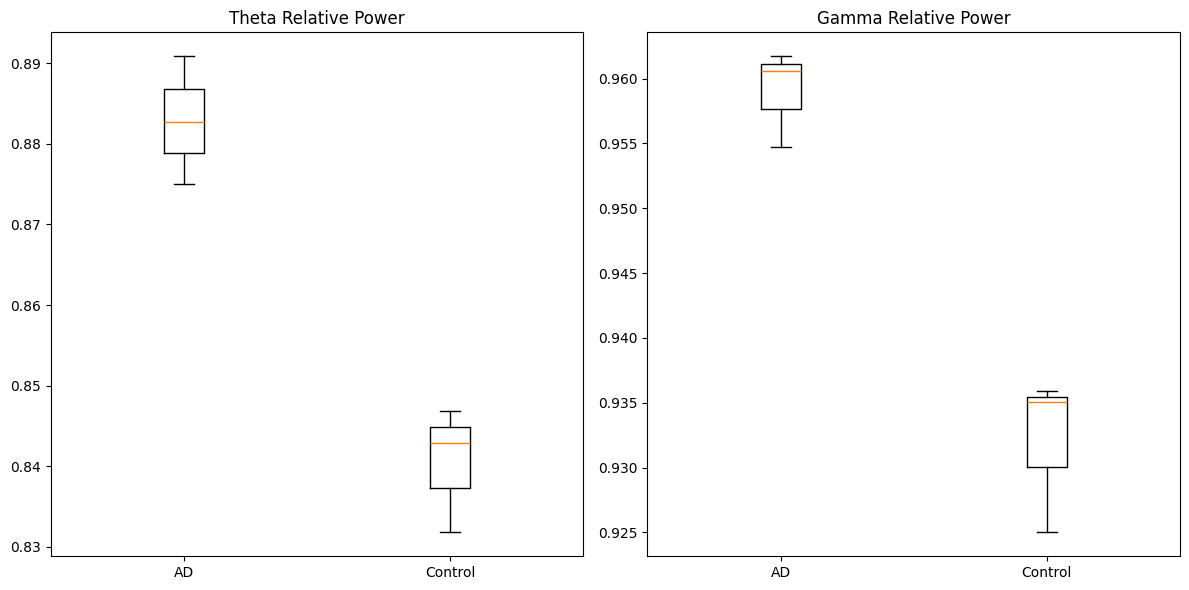

In [9]:
# data for absolute value is normal or homoscedastic (equal variance) so ahve to use Mann-whitney
# data is not paired (independent) (theta data for AD and control come from different patients) 
# so cant do theta_data - theta data AD_Fp1 – Control_Fp1 and see if not equal to 0 

# Statistical testing
def compare_groups(ad_data, ctrl_data, name):
    stat, p = mannwhitneyu(ad_data, ctrl_data)
    print(f"{name}: U={stat:.1f}, p={p:.4f}")
    return p

p_values = [
    compare_groups(results['AD_theta_abs'], results['CTRL_theta_abs'], "Theta Absolute Power"),
    compare_groups(results['AD_theta_rel'], results['CTRL_theta_rel'], "Theta Relative Power"),
    compare_groups(results['AD_gamma_abs'], results['CTRL_gamma_abs'], "Gamma Absolute Power"),
    compare_groups(results['AD_gamma_rel'], results['CTRL_gamma_rel'], "Gamma Relative Power")
]

# FDR correction
rejected, corrected_p = fdrcorrection(p_values)
print("\nFDR corrected p-values:", corrected_p)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.boxplot([results['AD_theta_rel'], results['CTRL_theta_rel']])
plt.title('Theta Relative Power')
plt.xticks([1, 2], ['AD', 'Control'])

plt.subplot(122)
plt.boxplot([results['AD_gamma_rel'], results['CTRL_gamma_rel']])
plt.title('Gamma Relative Power')
plt.xticks([1, 2], ['AD', 'Control'])
plt.tight_layout()
plt.show()

In [10]:
# computing 1 samp t-test
# Code from HW2